In [1]:
%pylab inline
import numpy as np
import jax
import jax.numpy as jnp
import shtns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [36]:
def j_amm_m(m):
    k = jnp.arange(1, m + 1)
    return jnp.sqrt(jnp.prod((2*k+1)/(2*k))/(4*jnp.pi))

j_amm_m(5)

Array(0.4641322, dtype=float32)

In [70]:
@jax.jit
def j_amm(m):
    def f(el, k):
        el *= (2*k + 1) / (2*k)
        return el, k
    el, _ = jax.lax.scan(f, 1.0, jnp.r_[1:m])
    return jnp.sqrt(el/(4*jnp.pi))

In [135]:
all_amm(5)

0 []
0 1.0
1 [1]
1 1.5
2 [1, 2]
2 1.875
3 [1, 2, 3]
3 2.1875
4 [1, 2, 3, 4]
4 2.4609375
5 [1, 2, 3, 4, 5]
5 2.70703125


array([0.28209479, 0.34549415, 0.3862742 , 0.41722382, 0.44253269,
       0.4641322 ])

In [134]:
def gen_ml(N):
    return np.array([[m, l] for m in range(N+1) for l in range(N+1) if m<=l])

def all_amm(N):
    amm = []
    for m in range(N+1):
        els = []
        print(m, list(range(1,m+1)))
        for k in range(1,m+1):
            els.append((2*k+1)/(2*k))
        print(m, np.prod(els))
        el = np.prod(els)/(4*np.pi)
        amm.append(np.sqrt(el))
    amm = np.array(amm)
    return amm

def all_amm_jitable(amm_out):
    # N = amm_out.size - 1
    for m in range(amm_out.size):
        el = numba.float64(1.0)
        for k in range(1,m+1):
            el *= (2*k+1)/(2*k)
        el /= 4*np.pi
        amm_out[m] = np.sqrt(el)

@jax.jit
def amn(m, n):
    nom = 4*n*n - 1
    den = n*n - m*m
    out = jnp.sqrt(nom/den)
    return out

@jax.jit
def bmn(m, n):
    l = (2*n + 1)/(2*n - 3)
    r = ((n - 1)*(n - 1) - m*m)/(n*n - m*m)
    return - jnp.sqrt(l*r)

def lat_grid(nlat):
    x = np.r_[:nlat] / nlat * np.pi
    cx = np.cos(x)
    return cx

In [136]:
np.r_[:5]

array([0, 1, 2, 3, 4])

In [3]:
# @jax.jit
def LT(amm: np.ndarray[1,np.float32],
       cx: np.ndarray[1,np.float32],
       fx: np.ndarray[2,np.complex64]) -> np.ndarray[1,np.complex64]:
    
    N = amm.size - 1  # lmax
    nlat = cx.size
    i = 0
    
    # since cx is a vector, this is vectorized over latitudes
    # TODO convert to scan, it won't really work otherwise
    acc = jnp.zeros_like(cx)
    for m in range(N+1):
        # eq 13
        n = m
        p0 = amm[m]*(1 - cx*cx)**(m/2)*(-1)**m
        print(i, m, n, p0[0]); i+=1
        if n == N:
            break
        # eq 14
        n += 1
        p1 = amn(m, n) * cx * p0
        print(i, m, n, p1[0]); i+=1
        if n == N:
            continue
        # eq 15 base case
        n += 1
        p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
        print(i, m, n, p2[0]); i+=1
        if n == N:
            continue
        # eq 15 iterate
        while n < N:
            p0, p1 = p1, p2
            n += 1
            p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
            print(i, m, n, p2[0]); i+=1
    return p2

The above doesn't actually do the transform, just a complex loop to generate the coefficients.  Since Jax wants a more functional approach, and that loop above could result in many extra nodes in the graph, we want to convert that in to a scan over `m,n` sequence, where we carry whatever required, and the result will be just the `m,n` vector which is the result.

When including the `fx` Fourier transformed data, it may be helpful to transpose the array for locality.

First we need to break the loop above into cases and a function to map a given step to the specific case,

In [104]:
# TODO may be useful/necessary to do all this as a closure over some constant data arrays?
# TODO may be useful to have a pytree to collect arrays?

from collections import namedtuple

# instances of this instead of many args, jax will flatten automatically
# LTRecurState = namedtuple('LTRecurState', 'stop m n p0 p1 p2'.split(' '))

from scipy.special import sph_harm
check_Pmn = lambda p, m, n, cx: \
    np.testing.assert_allclose(p, 
        sph_harm(m, n, 0, np.arccos(cx)).real, rtol=1e-3, atol=1e-3)

# DONE test coefficients match sph_harm
def make_lt_recur(lmax, nlat):
    
    amm = all_amm(lmax)
    cx = lat_grid(nlat)
    N = amm.size - 1
    ml = np.array([[m, l] for m in range(N+1) for l in range(N+1) if m<=l])
    amm_ = amm[ml[:,0]]

    def eq13(amm_m, m, n, _1, _2, _3):
        p0 = amm_m*(1 - cx*cx)**(m/2)*(-1)**m
        return p0, (p0, p1, p2)

    def eq14(_1, m, n, p0, _2, _3):
        p1 = amn(m, n) * cx * p0
        return p1, (p0, p1, p2)

    def eq15_base(_1, m, n, p0, p1, _2):
        p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
        return p2, (p0, p1, p2)

    def eq15_iter(_1, m, n, p0, p1, p2):
        p0, p1 = p1, p2
        p2 = amn(m, n)*cx*p1 + bmn(m, n)*p0
        return p2, (p0, p1, p2)
    
    def choose_eqn(ps, amm_m, m, n):
        return jax.lax.switch(
            n - m,
            [eq13, eq14, eq15_base, eq15_iter],
            amm_m, m, n, *ps)

    def scan_pmn_op(ps, x):
        amm_m, (m, n) = x['amm_'], x['ml']
        pmn, ps = choose_eqn(ps, amm_m, m, n)
        return ps, pmn

    p0, p1, p2 = jnp.zeros((3,nlat))
    scan_pmn_init = p0, p1, p2
    scan_pmn_seq = {'amm_': amm_, 'ml': ml}
    
    @jax.jit
    def scan_pmn():
        _, pmns = jax.lax.scan(scan_pmn_op, scan_pmn_init, scan_pmn_seq)
        return pmns

    return ml, cx, scan_pmn

ml, cx, gen_pmn = make_lt_recur(6, 32)
for (m, n), pmn in zip(ml, gen_pmn()):
    check_Pmn(pmn, m, n, cx)

In [142]:
ml, cx, gen_pmn = make_lt_recur(31, 32)
print(gen_pmn().shape)

0 []
0 1.0
1 [1]
1 1.5
2 [1, 2]
2 1.875
3 [1, 2, 3]
3 2.1875
4 [1, 2, 3, 4]
4 2.4609375
5 [1, 2, 3, 4, 5]
5 2.70703125
6 [1, 2, 3, 4, 5, 6]
6 2.9326171875
7 [1, 2, 3, 4, 5, 6, 7]
7 3.14208984375
8 [1, 2, 3, 4, 5, 6, 7, 8]
8 3.338470458984375
9 [1, 2, 3, 4, 5, 6, 7, 8, 9]
9 3.5239410400390625
10 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10 3.7001380920410156
11 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
11 3.868326187133789
12 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
12 4.02950644493103
13 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
13 4.184487462043762
14 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
14 4.333933442831039
15 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
15 4.478397890925408
16 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
16 4.618347825016827
17 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
17 4.754181584576145
18 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
18 4.8862421841477035
19 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

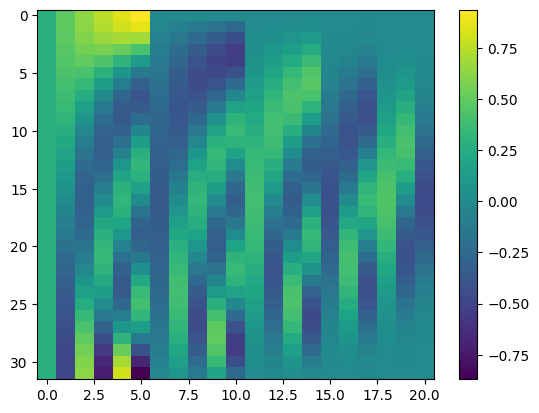

In [141]:
imshow(gen_pmn().T, aspect='auto'); colorbar()

It seems the values are correct now and in a scan, how long for different problem sizes?

In [112]:
for lmax, nlat in [(31, 32), (63, 64)]:
    ml, cx, gen_pmn = make_lt_recur(lmax, nlat)
    gen_pmn()
    %timeit gen_pmn()

21.7 µs ± 70.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
134 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [143]:
import nfjax.shtlc as lc

for lmax, nlat in [(16, 32), (31, 32), (63, 64)]:
    nlon, D = 2*nlat, 0.0004
    _, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True)
    np.testing.assert_equal(0, L.imag)
    L = L.real.astype('f')

    @jax.jit
    def apply_L(L, x, np=jnp):
        X = np.fft.rfft(x, axis=1)
        X = np.hstack(
            (np.einsum('abc,ca->ba', L, X[:,:lmax]),
             np.zeros((X.shape[0], X.shape[1] - lmax), jnp.complex64)
            )
        )
        y = np.real(np.fft.irfft(X, axis=1))
        return y

    x0 = jnp.array(np.random.randn(nlat, nlon).astype('f'))
    x1 = apply_L(L, x0)
    %timeit apply_L(L, x0)
    
    ml, cx, gen_pmn = make_lt_recur(lmax, nlat)
    gen_pmn()
    @jax.jit
    def just_FFT(x, np=jnp):
        X = np.fft.rfft(x, axis=1)
        #gen_pmn()
        y = np.real(np.fft.irfft(X, axis=1))
        return y
    x1 = just_FFT(x0)
    %timeit just_FFT(x0)

20.4 µs ± 61.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
0 []
0 1.0
1 [1]
1 1.5
2 [1, 2]
2 1.875
3 [1, 2, 3]
3 2.1875
4 [1, 2, 3, 4]
4 2.4609375
5 [1, 2, 3, 4, 5]
5 2.70703125
6 [1, 2, 3, 4, 5, 6]
6 2.9326171875
7 [1, 2, 3, 4, 5, 6, 7]
7 3.14208984375
8 [1, 2, 3, 4, 5, 6, 7, 8]
8 3.338470458984375
9 [1, 2, 3, 4, 5, 6, 7, 8, 9]
9 3.5239410400390625
10 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10 3.7001380920410156
11 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
11 3.868326187133789
12 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
12 4.02950644493103
13 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
13 4.184487462043762
14 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
14 4.333933442831039
15 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
15 4.478397890925408
16 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
16 4.618347825016827
8.18 µs ± 16.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
30 µs ± 37 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
0 []
0 1.

21 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [145]:
L.shape
import scipy.io
scipy.io.savemat('L_63_64.mat', {'L': L})

So the two sizes have cost about 22us and 250us w/ matrix form, and recur (estimating at 2x gen_pmn above) is about 40us and 270us, so about equal for the 64x128 grid.  It seems worthwhile to continue implementing since it requires  less memory than the `lmax*nlat*nlat` form, though even then it isn't much: 

In [116]:
for lmax, nlat in [(31, 32), (63, 64), (127, 128)]:
    print(lmax*nlat*nlat * 4 / 1024, 'kB')

124.0 kB
1008.0 kB
8128.0 kB
